In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import collections
from sklearn import model_selection
import math
import os
import tqdm.notebook as tqdm
import sys
sys.path.append('../')


from model import create_model
from generator import preprocess_input
from optimizer import get_optimizer
from config import config_1 as config

tf.config.set_visible_devices([], 'GPU')

input_path = '../../input/landmark-retrieval-2020/'

In [76]:
def _prepare_df(df_orig, alpha=0.5):
    df = df_orig.copy()
    counts_map = dict(
        df.groupby('landmark_id')['path'].agg(lambda x: len(x)))
    df['counts'] = df['landmark_id'].map(counts_map)
    df['weight'] = (
        (1/df.counts**alpha) / (1/df.counts**alpha).max()).astype(np.float32)
    df['label'] = df['label'].astype(np.int32)
    df['image_target_ratio'] = df['image_target_ratio'].astype(np.float32)
    return df



df = pd.read_csv('../../input/modified_train.csv')
df = _prepare_df(df)

In [112]:
d = {'17660ef415d37059': 0.4, 'fb09f1e98c6d2f70': 0.99, 'cd41bf948edc0340': 0.2}


In [113]:
df['id'].isin(d.keys())

0           True
1          False
2           True
3           True
4          False
           ...  
1580465    False
1580466    False
1580467    False
1580468    False
1580469    False
Name: id, Length: 1580470, dtype: bool

In [114]:
df['weight'] = np.where(df['id'].isin(d.keys()), df['weight']*df['id'].map(d), df['weight'])

In [115]:
df

,Unnamed: 0,id,landmark_id,path,image_shape,image_ratio,image_target_ratio,image_target_ratio_group,label,counts,weight,weight_adjusted
0,0,17660ef415d37059,1,../input/landmark-retrieval-2020/train/1/7/6/1...,"(800, 533)",1.500938,1.501,5,0,4,0.025600,0.400000
1,1,92b6290d571448f6,1,../input/landmark-retrieval-2020/train/9/2/b/9...,"(800, 534)",1.498127,1.501,5,0,4,0.900000,0.900000
2,2,cd41bf948edc0340,1,../input/landmark-retrieval-2020/train/c/d/4/c...,"(512, 800)",0.640000,0.667,1,0,4,0.060000,0.707107
3,3,fb09f1e98c6d2f70,1,../input/landmark-retrieval-2020/train/f/b/0/f...,"(800, 532)",1.503759,1.501,5,0,4,0.960596,0.707107
4,4,25c9dfc7ea69838d,7,../input/landmark-retrieval-2020/train/2/5/c/2...,"(600, 800)",0.750000,0.750,2,1,8,0.100000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
1580465,1580465,72c3b1c367e3d559,203092,../input/landmark-retrieval-2020/train/7/2/c/7...,"(533, 800)",0.666250,0.667,1,81312,8,0.500000,0.500000
1580466,1580466,7a6a2d9ea92684a6,203092,../input/landmark-retrieval-2020/train/7/a/6/7...,"(532, 800)",0.665000,0.667,1,81312,8,0.500000,0.500000
1580467,1580467,9401fad4c497e1f9,203092,../input/landmark-retrieval-2020/train/9/4/0/9...,"(533, 800)",0.666250,0.667,1,81312,8,0.500000,0.500000
1580468,1580468,aacc960c9a228b5f,203092,../input/landmark-retrieval-2020/train/a/a/c/a...,"(533, 800)",0.666250,0.667,1,81312,8,0.500000,0.500000


In [109]:
df

,Unnamed: 0,id,landmark_id,path,image_shape,image_ratio,image_target_ratio,image_target_ratio_group,label,counts,weight,weight_adjusted
0,0,17660ef415d37059,1,../input/landmark-retrieval-2020/train/1/7/6/1...,"(800, 533)",1.500938,1.501,5,0,4,0.1600,0.400000
1,1,92b6290d571448f6,1,../input/landmark-retrieval-2020/train/9/2/b/9...,"(800, 534)",1.498127,1.501,5,0,4,0.9000,0.900000
2,2,cd41bf948edc0340,1,../input/landmark-retrieval-2020/train/c/d/4/c...,"(512, 800)",0.640000,0.667,1,0,4,0.3000,0.707107
3,3,fb09f1e98c6d2f70,1,../input/landmark-retrieval-2020/train/f/b/0/f...,"(800, 532)",1.503759,1.501,5,0,4,0.9801,0.707107
4,4,25c9dfc7ea69838d,7,../input/landmark-retrieval-2020/train/2/5/c/2...,"(600, 800)",0.750000,0.750,2,1,8,0.1000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
1580465,1580465,72c3b1c367e3d559,203092,../input/landmark-retrieval-2020/train/7/2/c/7...,"(533, 800)",0.666250,0.667,1,81312,8,0.5000,0.500000
1580466,1580466,7a6a2d9ea92684a6,203092,../input/landmark-retrieval-2020/train/7/a/6/7...,"(532, 800)",0.665000,0.667,1,81312,8,0.5000,0.500000
1580467,1580467,9401fad4c497e1f9,203092,../input/landmark-retrieval-2020/train/9/4/0/9...,"(533, 800)",0.666250,0.667,1,81312,8,0.5000,0.500000
1580468,1580468,aacc960c9a228b5f,203092,../input/landmark-retrieval-2020/train/a/a/c/a...,"(533, 800)",0.666250,0.667,1,81312,8,0.5000,0.500000


In [64]:
def _group_shuffle_df(df_orig):

    df = df_orig.copy()

    df = df.sample(frac=0.5, replace=False, weights='probs', axis=0)
 
    return df

df_ = _group_shuffle_df(df)

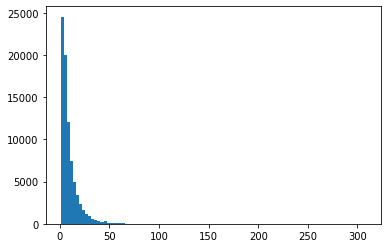

In [65]:
_, counts = np.unique(df_.label, return_counts=True)
plt.hist(counts, bins=100);

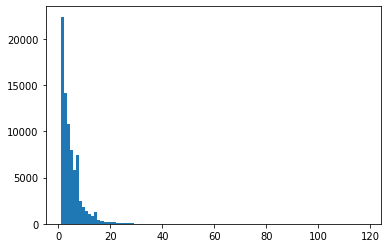

In [59]:
_, counts = np.unique(df_.label, return_counts=True)
plt.hist(counts, bins=100);

(800, 533, 3)


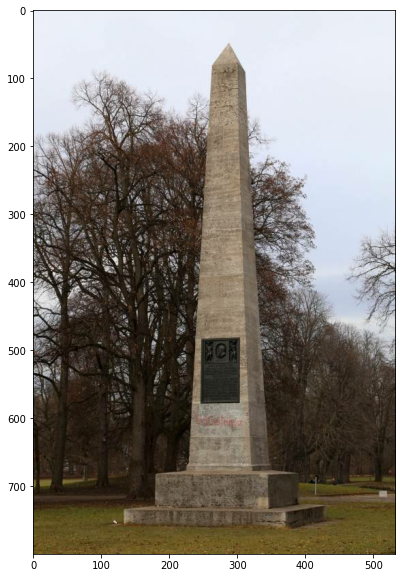

In [5]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    return tf.image.decode_jpeg(image, channels=3)


image = read_image('../'+df_.path[0])
def _random_fliplr(image, p=0.5):
    r = tf.random.uniform(())
    mirror_cond = tf.math.less(r, 0.05)
    image = tf.cond(
        mirror_cond,
        lambda: tf.reverse(image, [1]),
        lambda: image
    )
    return image

#image = tf.image.flip_left_right(image)
image = _random_fliplr(image)
print(image.shape)
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [6]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.76143813>

In [52]:
arr = [1, 0, 3, 1, 3, 1, 5, 1, 3, 6, 9]

def countingSort(arr):
    aux = [0]*10
    for a in arr:
        aux[a] += 1
    print(aux)
    sarr = []
    for i in range(len(aux)):
        if aux[i] != 0:
            for _ in range(aux[i]):
                sarr.append(i)
    print(sarr)
    
    
countingSort(arr)

[1, 4, 0, 3, 0, 1, 1, 0, 0, 1]
[0, 1, 1, 1, 1, 3, 3, 3, 5, 6, 9]


In [25]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    return tf.image.decode_jpeg(image, channels=3)

def _pixel_transform(image,
                     hue_delta=0.0,
                     saturation_delta=0.3,
                     contrast_delta=0.1,
                     brightness_delta=0.2):
    if hue_delta > 0:
        image = tf.image.random_hue(
            image, hue_delta)
    if saturation_delta > 0:
        image = tf.image.random_saturation(
            image, 1-saturation_delta, 1+saturation_delta)
    if contrast_delta > 0:
        image = tf.image.random_contrast(
            image, 1-contrast_delta, 1+contrast_delta)
    if brightness_delta > 0:
        image = tf.image.random_brightness(
            image, brightness_delta)
    return image

df = pd.read_csv('../../input/modified_train.csv')

NameError: name 'pd' is not defined

In [26]:
files_paths = glob.glob(input_path + 'train/*/*/*/*')
mapping = {}
for path in files_paths:
    mapping[path.split('/')[-1].split('.')[0]] = path[3:]

In [30]:
df[df.landmark_id == 175739]

,id,landmark_id,path,image_shape,image_ratio,image_target_ratio,image_target_ratio_group
1365663,0ba0f1bbc5aefa74,175739,../input/landmark-retrieval-2020/train/0/b/a/0...,"(598, 800)",0.747500,0.7500,2
1365664,0dbc0527762c98ab,175739,../input/landmark-retrieval-2020/train/0/d/b/0...,"(800, 527)",1.518027,1.5010,5
1365665,0e5eb72c38e33288,175739,../input/landmark-retrieval-2020/train/0/e/5/0...,"(800, 423)",1.891253,1.8000,6
1365666,157452846771503b,175739,../input/landmark-retrieval-2020/train/1/5/7/1...,"(800, 600)",1.333333,1.3334,4
1365667,17304e193e64eef3,175739,../input/landmark-retrieval-2020/train/1/7/3/1...,"(800, 410)",1.951220,1.8000,6
1365668,1f557b44e3e7b4c8,175739,../input/landmark-retrieval-2020/train/1/f/5/1...,"(800, 452)",1.769912,1.8000,6
1365669,2de943db962c2ca1,175739,../input/landmark-retrieval-2020/train/2/d/e/2...,"(800, 600)",1.333333,1.3334,4
1365670,2f0b13fa5293ad6c,175739,../input/landmark-retrieval-2020/train/2/f/0/2...,"(533, 800)",0.666250,0.6670,1
1365671,375b78b65ba867d2,175739,../input/landmark-retrieval-2020/train/3/7/5/3...,"(558, 800)",0.697500,0.6670,1
1365672,44eb3a6824ea546e,175739,../input/landmark-retrieval-2020/train/4/4/e/4...,"(607, 800)",0.758750,0.7500,2


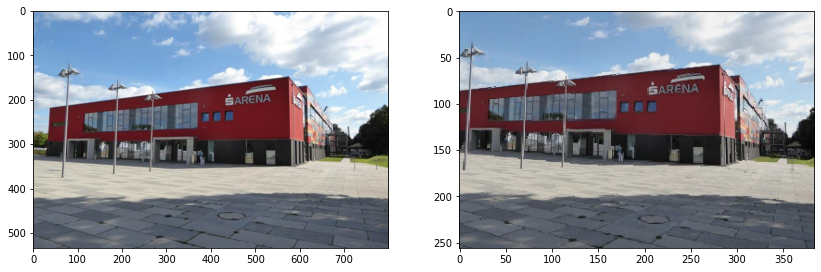

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
image = read_image(df.iloc[11].path)
image_aug = preprocess_input(image, (384, 384), ratio=-1, augment=True)
axes[0].imshow(image)
axes[1].imshow(image_aug)

(533, 800, 3)


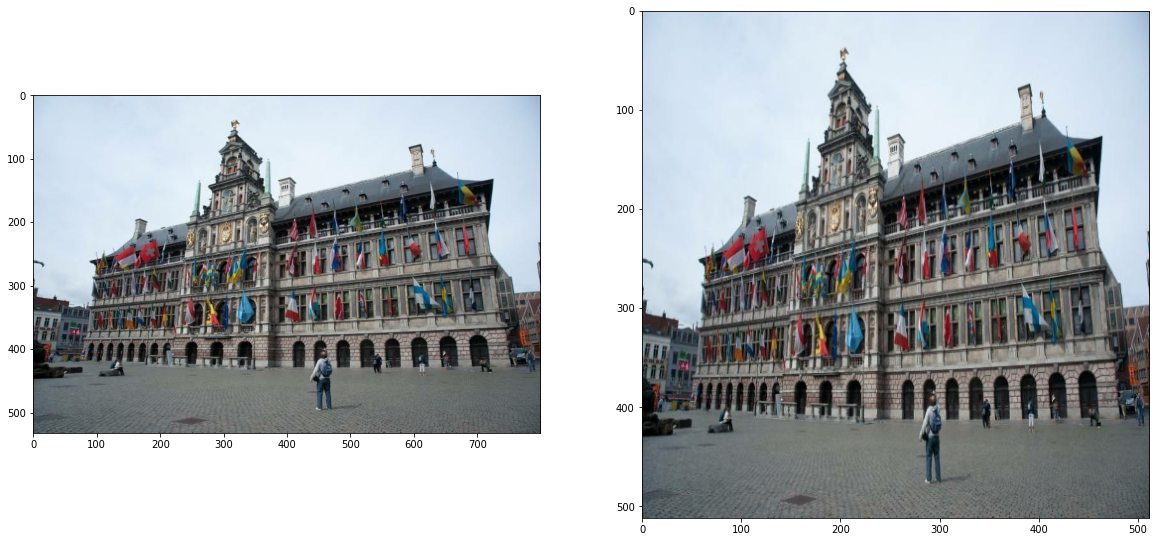

In [3]:
im1= read_image(data[data.landmark_id == 201898].iloc[2].path)
print(im1.shape)
im2 = tf.image.resize(
            im1, (512, 512), method='bilinear')
im2 = tf.cast(im2, dtype='uint8')

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(im1)
axes[1].imshow(im2)

(1024, 682, 3)


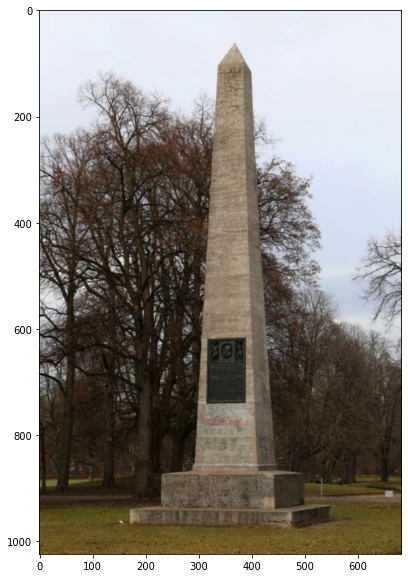

In [11]:
from generator import preprocess_input

image2 = preprocess_input(image, (1024, 1024), ratio=-1, augment=False)

print(image2.shape)
plt.figure(figsize=(10, 10))
plt.imshow(image2)

#(800, 533, 3)

In [17]:
1024/682

1.5009380863039399

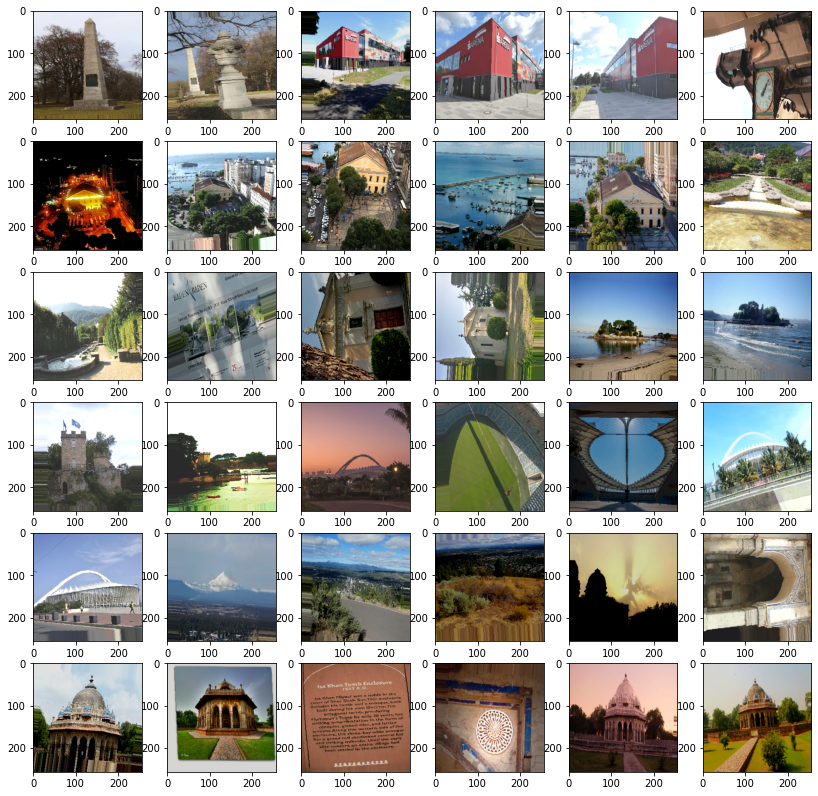

In [6]:
for x, y in dataset.take(1):
    pass

fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(x[i].numpy())

In [ ]:
def _get_transform_matrix(rotation, shear, hzoom, wzoom, hshift, wshift):

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])

    # convert degrees to radians
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')

    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    rot_mat = get_3x3_mat([c1,    s1,   zero ,
                           -s1,   c1,   zero ,
                           zero,  zero, one ])

    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_mat = get_3x3_mat([one,  s2,   zero ,
                             zero, c2,   zero ,
                             zero, zero, one ])

    zoom_mat = get_3x3_mat([one/hzoom, zero,      zero,
                            zero,      one/wzoom, zero,
                            zero,      zero,      one])

    shift_mat = get_3x3_mat([one,  zero, hshift,
                             zero, one,  wshift,
                             zero, zero, one   ])

    return tf.matmul(
        tf.matmul(rot_mat, shear_mat),
        tf.matmul(zoom_mat, shift_mat)
    )

def _spatial_transform(image,
                       rotation=5.0,
                       shear=2.0,
                       hzoom=8.0,
                       wzoom=8.0,
                       hshift=8.0,
                       wshift=8.0,
                       p=0.5):
    

    dim = tf.gather(tf.shape(image), 0)
    xdim = dim % 2
    
    # random rotation, shear, zoom and shift
    r1, r2, r3, r4 = tf.random.uniform(shape=(4,), minval=1, maxval=1)
    if r1 > p:
        rotation = rotation * tf.random.normal([1], dtype='float32')
    else:
        rotation = tf.constant([0.0])
        
    if r2 > p:
        shear = shear * tf.random.normal([1], dtype='float32')
    else:
        shear = tf.constant([0.0])
        
    if r3 > p:
        hzoom = 1.0 + tf.random.normal([1], dtype='float32') / hzoom
        wzoom = 1.0 + tf.random.normal([1], dtype='float32') / wzoom
    else:
        hzoom, wzoom = tf.constant([1.0]), tf.constant([1.0])
    
    if r4 > p:
        hshift = hshift * tf.random.normal([1], dtype='float32')
        wshift = wshift * tf.random.normal([1], dtype='float32')
    else:
        hshift, wshift = tf.constant([0.0]), tf.constant([0.0])

    m = _get_transform_matrix(
        rotation, shear, hzoom, wzoom, hshift, wshift)

    # list destination pixel indices
    x = tf.repeat(tf.range(dim//2, -dim//2,-1), dim)
    y = tf.tile(tf.range(-dim//2, dim//2), [dim])
    z = tf.ones([dim*dim], dtype='int32')
    idx = tf.stack([x,y,z])

    # rotate destination pixels onto origin pixels
    idx2 = tf.matmul(m, tf.cast(idx, dtype='float32'))
    idx2 = tf.cast(idx2, dtype='int32')
    idx2 = tf.clip_by_value(idx2, -dim//2+xdim+1, dim//2)

    # find origin pixel values
    idx3 = tf.stack([dim//2-idx2[0,], dim//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))

    image = tf.reshape(d, [dim, dim, 3])
    
    return image

def _pixel_transform(image,
                     hue_delta=0.0,
                     saturation_delta=0.0,
                     contrast_delta=0.1,
                     brightness_delta=0.2):
    
    if hue_delta > 0:
        image = tf.image.random_hue(
            image, hue_delta)
    if saturation_delta > 0:
        image = tf.image.random_saturation(
            image, 1-saturation_delta, 1+saturation_delta)
    if contrast_delta > 0:
        image = tf.image.random_contrast(
            image, 1-contrast_delta, 1+contrast_delta)
    if brightness_delta > 0:
        image = tf.image.random_brightness(
            image, brightness_delta)
    
    shape = image.shape
    
    return image




In [ ]:
print(im1.shape)
im_aug = _spatial_transform(im2)
print(im_aug.shape)
im_aug = _pixel_transform(im_aug)
plt.imshow(im_aug)

In [32]:
model1 = create_model(
    backbone=config['backbone'],
    input_shape=config['input_size'],
    n_classes=config['n_classes'],
    dense_units=config['dense_units'],
    dropout_rate=config['dropout_rate'],
    regularization_factor=config['regularization_factor'],
    loss=config['loss']['type'],
    scale=config['loss']['scale'],
    margin=config['loss']['margin'],
)
model1.load_weights('../../output/weights/model.h5')

for layer in model1.layers:
    print(layer.name)
model1 = tf.keras.Model(
    inputs=model1.get_layer('input/image').input,
    outputs=model1.get_layer('head/dense').output
)

input/image
efficientnet-b0
head/gem_pooling
head/dropout
head/dense
head/sync_batch_norm
input/label
head/arc_margin


distance between anchor and positive = 0.8088184
distance between anchor and negative = 1.2762007


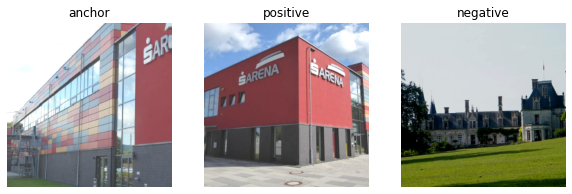

In [66]:
im1 = read_image(data.iloc[5].path)
im2 = read_image(data.iloc[6].path)
im3 = read_image(data.iloc[42023].path) # 42023

im1 = preprocess_input(
        im1, config['input_size'][:2], config['pad_on_resize'])
im2 = preprocess_input(
        im2, config['input_size'][:2], config['pad_on_resize'])
im3 = preprocess_input(
        im3, config['input_size'][:2], config['pad_on_resize'])

emb1 = tf.math.l2_normalize(model1(im1[tf.newaxis]), axis=1)[0]
emb2 = tf.math.l2_normalize(model1(im2[tf.newaxis]), axis=1)[0]
emb3 = tf.math.l2_normalize(model1(im3[tf.newaxis]), axis=1)[0]


fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for lab, im, ax in zip(['anchor', 'positive', 'negative'], [im1, im2, im3], axes.reshape(-1)):
    ax.imshow(im);
    ax.set_title(lab)
    ax.axis('off')
    
print('distance between anchor and positive =', np.linalg.norm(emb1-emb2))
print('distance between anchor and negative =', np.linalg.norm(emb1-emb3))


# distance between anchor and positive = 0.94654644
# distance between anchor and negative = 1.3443389

# distance between anchor and positive = 0.96240777
# distance between anchor and negative = 1.3401006

In [18]:
served_model =tf.saved_model.load('../../output/served_models/model')
model2 = served_model.signatures["serving_default"]

distance between anchor and positive = 6.631204
distance between anchor and negative = 11.284741


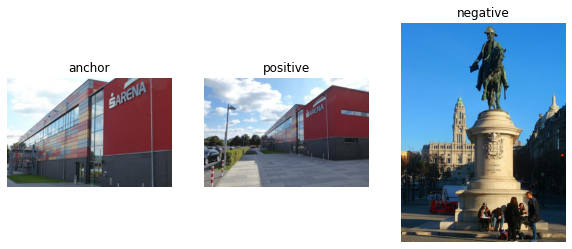

In [19]:
im1 = read_image(data.iloc[5].path)
im2 = read_image(data.iloc[8].path)
im3 = read_image(data.iloc[1320].path) # 42023

emb1 = model2(input_image=im1)['global_descriptor']
emb2 = model2(input_image=im2)['global_descriptor']
emb3 = model2(input_image=im3)['global_descriptor']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for lab, im, ax in zip(['anchor', 'positive', 'negative'], [im1, im2, im3], axes.reshape(-1)):
    ax.imshow(im);
    ax.set_title(lab)
    ax.axis('off')
    
print('distance between anchor and positive =', np.linalg.norm(emb1-emb2))
print('distance between anchor and negative =', np.linalg.norm(emb1-emb3))

In [20]:
%timeit model2(input_image=im1)['global_descriptor']

97 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [205]:
# distance between anchor and positive = 0.74888474
# distance between anchor and negative = 1.4010392

# distance between anchor and positive = 0.6329748
# distance between anchor and negative = 1.4207379

In [6]:
print(emb1[:512].numpy().max())
print(emb1[512:].numpy().max())

1.2446762


ValueError: zero-size array to reduction operation maximum which has no identity

In [94]:
print(emb1[:512].numpy().min())
print(emb1[512:].numpy().min())

-0.30767334
-0.17788318


In [ ]:
print(emb1)

In [ ]:
print(emb2)

In [ ]:
emb = np.random.uniform(0, 1, size=(256, 256, 3))

In [ ]:
out = model(emb[np.newaxis])

In [ ]:
tf.math.l2_normalize(out, axis=1)

In [ ]:
tf.math.l2_normalize(out[0])